Monopole Data Processing...


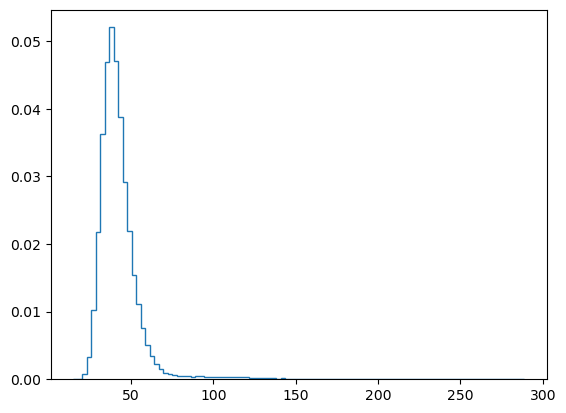

In [5]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def give_sig_weights(monopole_df):
    file = uproot.open("/home/zhonghua/data/exposure_Gaisser.root")
    h1 = file["h1"]
    h2 = file["h2"]
    # 获取直方图的所有数据
    values = h1.values()        # bin内容（纵坐标）
    h2_values = h2.values()        # bin内容（纵坐标）
    edges = h1.axis().edges()   # bin边界（横坐标）
    h2_edges = h2.axis().edges()   # bin边界（横坐标）
    centers = h1.axis().centers()  # bin中心
    h2_centers = h2.axis().centers()  # bin中心

    values = np.array(h1.values())
    edges = np.array(h1.axis().edges())
    centers = np.array(h1.axis().centers())
    S=np.pi * 1000**2
    parker=1e-15 * 1e4 
    nums=[]
    for i, theta in enumerate(centers):
        cosine_theta = np.cos(np.deg2rad(theta))
        area = S * cosine_theta
        exposure = values[i] * area
        num_i = exposure * parker
        nums.append(num_i)

    weights=[num_i/251000/h2_values[i]/86400 for i, num_i in enumerate(nums)]
    theta_degrees = monopole_df["theta"] * 180 / np.pi
    monopole_weights = []
    for theta in theta_degrees:
        if theta > max(centers) or theta < 0:
            weight = weights[-1] if theta > max(centers) else 0
        else:
            bin_id = np.digitize(theta, edges) - 1
            weight = weights[bin_id]
        monopole_weights.append(weight)
  
    monopole_df["weight"] = monopole_weights
    # print(f"======> Total expected monopole events after weighting: {monopole_df['weight'].sum()} ======")
    return monopole_df

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("Monopole Data Processing...")
mn_npz_file =  "/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz"
mn_data = np.load(mn_npz_file, allow_pickle=True)
hitsE = mn_data['hitsE']; hitsM = mn_data['hitsM']; mn_df = pd.DataFrame(mn_data['params'], columns=mn_data['param_names'])
mn_df = give_sig_weights(mn_df)
mn_df = mn_df[mn_df['dr']>0]
mn_df['rec_x'] = pd.to_numeric(mn_df['rec_x'], errors='coerce'); mn_df['rec_y'] = pd.to_numeric(mn_df['rec_y'], errors='coerce'); mn_df['rec_r'] = np.sqrt(mn_df['rec_x']**2 + mn_df['rec_y']**2)
mn_Rmean_anomaly_df = mn_df[mn_df['R_mean'] > 100]; index_anomaly = mn_Rmean_anomaly_df.index
mn_normal_df = mn_df.drop(index_anomaly); index_normal = mn_normal_df.index

plt.hist(mn_df['R_mean'], bins=100, histtype='step', density=True, label='All')
plt.show()


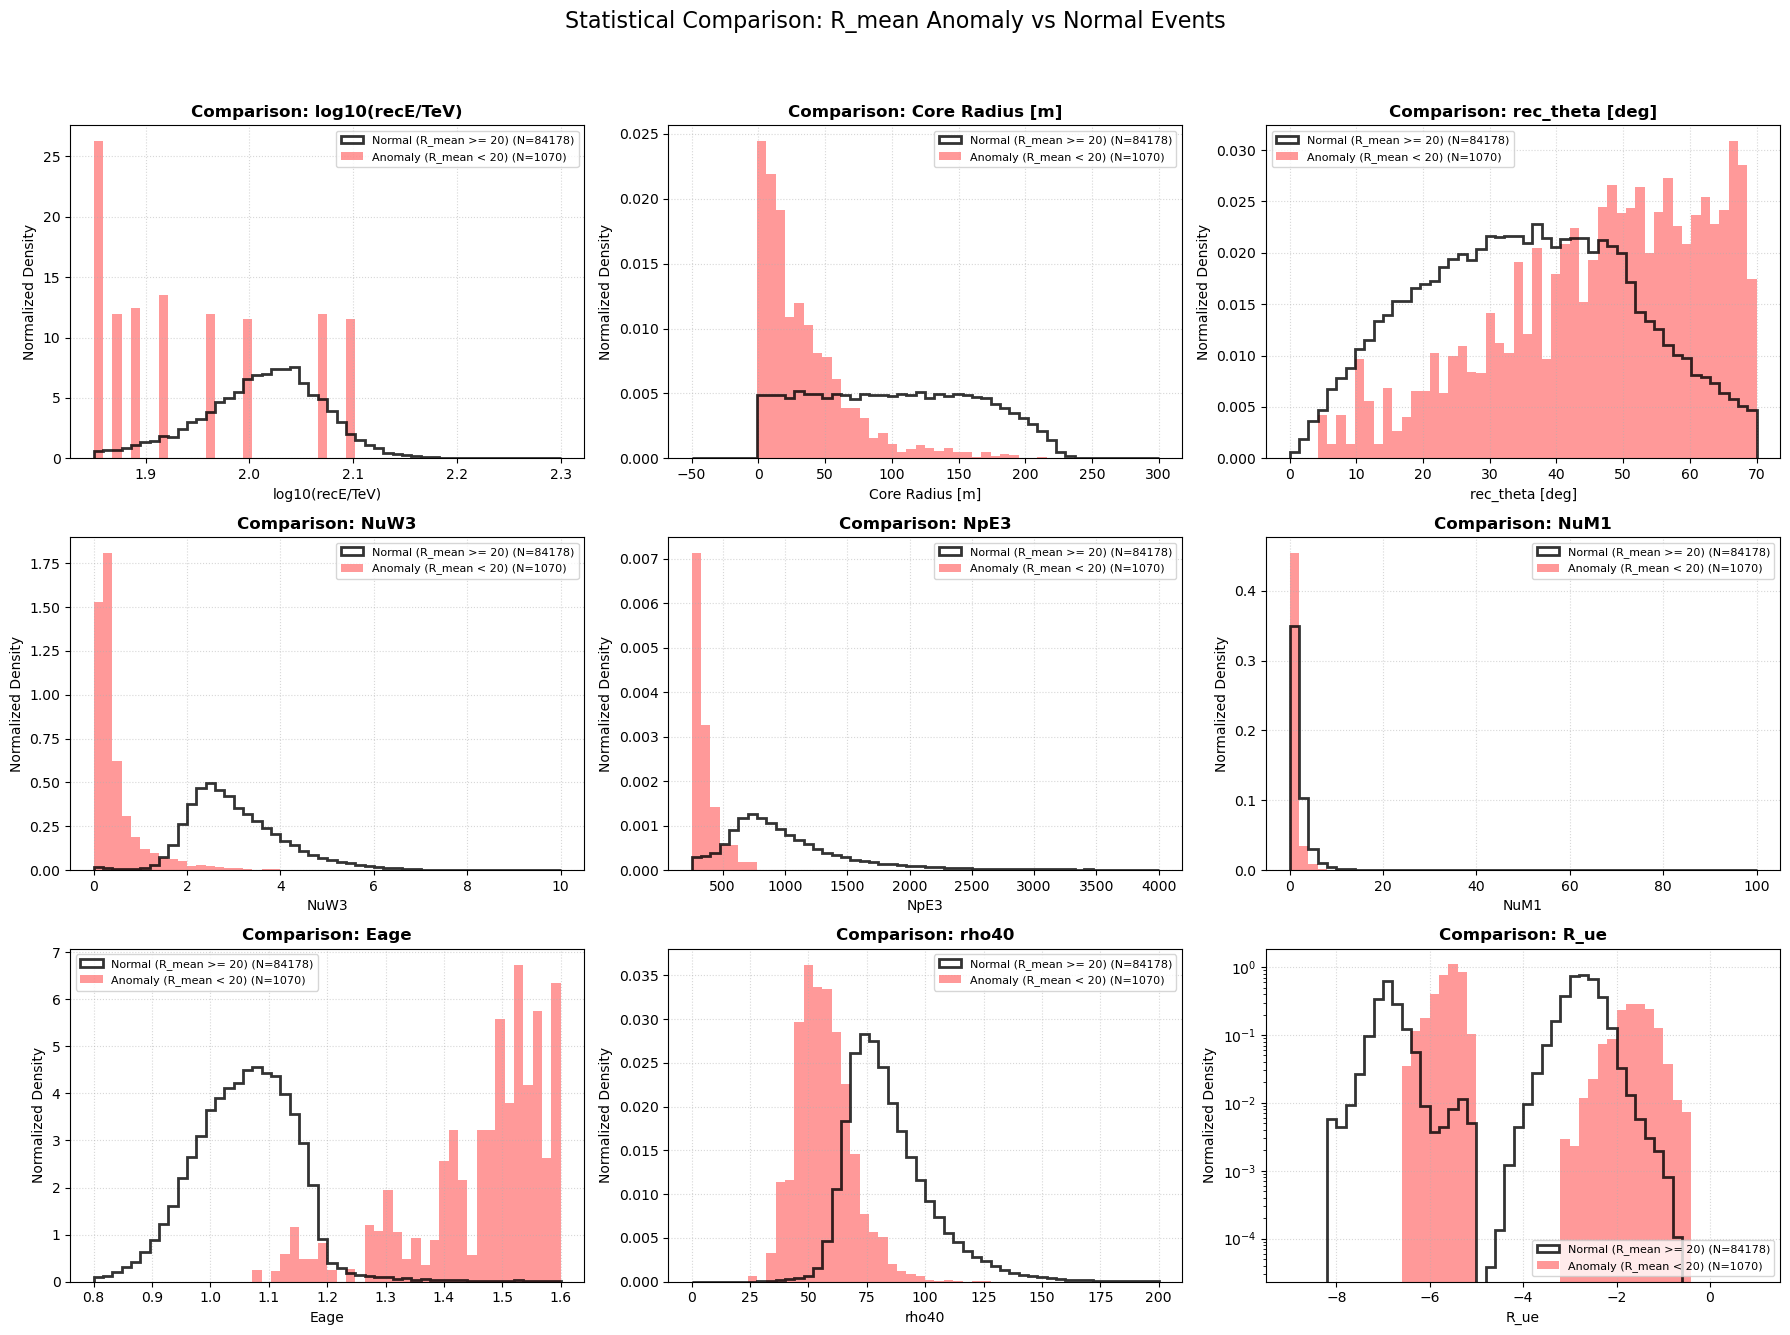

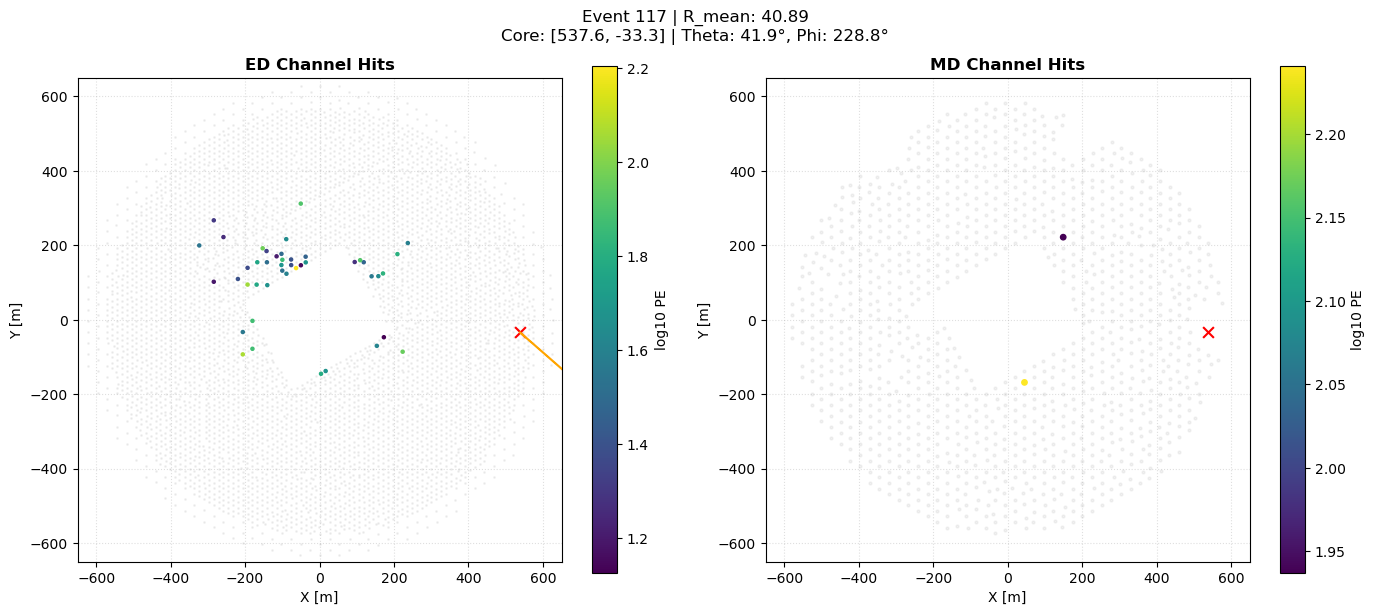

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def load_pos(flag:int):
    ED_pos_file = None
    MD_pos_file = None
    script_dir = "/home/zhonghua/data/Dataset_Filted/config"
    if flag==7:
        ED_pos_file=f'{script_dir}/ED_pos_all_MC.txt'
        MD_pos_file=f'{script_dir}/MD_pos_all_MC.txt'
    else:
        MD_pos_file=f'{script_dir}/MD_pos_1188.txt'
        if flag>20191224 and flag<20201201:
            ED_pos_file=f'{script_dir}/ED_pos_half.txt'
        elif flag>20201130 and flag<20210720:
            ED_pos_file=f'{script_dir}/ED_pos_3978.txt'
        elif flag>20210719 and flag<20210807:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20210720.txt'
        elif flag>20210806 and flag<20210818:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20210807.txt'
        elif flag>20210817 and flag<20220525:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20210818.txt'
        elif flag>20220525 and flag<20220601:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20220520.txt'
        elif flag>20220531 and flag<20220705:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20220601.txt'
        elif flag>20220704:
            ED_pos_file=f'{script_dir}/ED_pos_5216up_20220705.txt'
    
    if ED_pos_file is not None:
        if os.path.exists(ED_pos_file) and os.path.exists(MD_pos_file):
            ED_pos=pd.read_csv(ED_pos_file,  sep=r'\s+',   skiprows=1,header=None, names=["id","x","y","z"])
            MD_pos=pd.read_csv(MD_pos_file,  sep=r'\s+',   skiprows=1,header=None, names=["id","x","y","z"])
            return ED_pos,MD_pos
    else:

        raise ValueError("wrong flag")
    
def event_plot_npz(index, hitsE_all, hitsM_all, df_params, flag=7, figpath=None):
    # 1. 加载阵列全量位置作为背景
    # 依然需要 load_pos 来获取该 flag 下所有探测器的坐标
    ED_pos, MD_pos = load_pos(flag)

    # 2. 提取当前事例的 hit 数据 (N, 5) -> x, y, r, pe, dt
    hE = hitsE_all[index]
    hM = hitsM_all[index]
    
    # 提取重建参数
    row = df_params.iloc[index]
    core = [row['rec_x'], row['rec_y']]
    theta, phi = row['rec_theta'], row['rec_phi']

    # 3. 计算指向箭头
    dy = np.sin(theta) * np.cos(phi)
    dx = -np.sin(theta) * np.sin(phi)
    dr = np.sqrt(dx**2 + dy**2)
    arrow_len = 200
    if dr > 0:
        dx, dy = dx * arrow_len / dr, dy * arrow_len / dr

    # 4. 开始绘图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- 左图：ED Hits ---
    # 背景：所有 ED 位置
    ax1.scatter(ED_pos['x'], ED_pos['y'], c='lightgray', s=1, alpha=0.3, label='Detectors')
    # 前景：命中的 ED (hE[:, 3] 是 pe)
    sc1 = ax1.scatter(hE[:, 0], hE[:, 1], c=np.log10(hE[:, 3] + 1), 
                      cmap='viridis', s=5, zorder=3)
    
    ax1.scatter(core[0], core[1], c='red', s=60, marker='x', label='Core', zorder=5)
    ax1.arrow(core[0], core[1], dx, dy, color='orange', width=2, head_width=15, zorder=6)
    
    ax1.set_title('ED Channel Hits', fontweight='bold')
    fig.colorbar(sc1, ax=ax1, label='log10 PE')

    # --- 右图：MD Hits ---
    # 背景：所有 MD 位置
    ax2.scatter(MD_pos['x'], MD_pos['y'], c='lightgray', s=4, alpha=0.3)
    # 前景：命中的 MD
    sc2 = ax2.scatter(hM[:, 0], hM[:, 1], c=np.log10(hM[:, 3] + 1), 
                      cmap='viridis', s=15, zorder=3)
    
    ax2.scatter(core[0], core[1], c='red', s=60, marker='x', zorder=5)
    
    ax2.set_title('MD Channel Hits', fontweight='bold')
    fig.colorbar(sc2, ax=ax2, label='log10 PE')

    # 格式化标题
    res_info = (f"Event {index} | R_mean: {row['R_mean']:.2f}\n"
                f"Core: [{core[0]:.1f}, {core[1]:.1f}] | "
                f"Theta: {np.degrees(theta):.1f}°, Phi: {np.degrees(phi):.1f}°")
    plt.suptitle(res_info, fontsize=12)
    
    for ax in [ax1, ax2]:
        ax.set_aspect('equal') # 保持物理比例
        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        ax.set_xlim(-650,650)
        ax.set_ylim(-650,650)
        ax.grid(True, linestyle=':', alpha=0.4)

    plt.tight_layout()
    # if figpath:
    #     plt.savefig(figpath, dpi=150, bbox_inches='tight')
    plt.show()


def plot_anomaly_comparison(df_anomaly, df_normal,):
    # 1. 定义需要比较的参数、显示范围及标签
    param_configs = {
        'recE':      {'range': (1.85, 2.3), 'label': 'log10(recE/TeV)'},
        'dr':     {'range': (-50, 300),     'label': 'Core Radius [m]'},
        'rec_theta': {'range': (0, 70),      'label': 'rec_theta [deg]'},
        'NuW3':      {'range':  (0, 10),   'label': 'NuW3'},
        'NpE3':      {'range': (250, 4000),  'label': 'NpE3'},
        'NuM1':      {'range':  (0, 100),   'label': 'NuM1'},
        'Eage':      {'range': (0.8, 1.6),   'label': 'Eage'},
        'rho40':     {'range':  (0, 200),   'label': 'rho40'},
        'R_ue':      {'range': (-9, 1),      'label': 'R_ue'},
        # 'pincness':  {'range':  (0.5, 1),   'label': 'pincness'},
        # 'R_mean':    {'range': (0, 150),     'label': 'R_mean [m]'},
        
        
    }

    # 2. 配置对比组的显示样式
    # 我们将异常事例用红色填充表示，正常事例用黑色线条表示
    comparison_sources = {
        'Normal (R_mean >= 20)': {
            'df': df_normal,
            'color': 'black',
            'style': {'histtype': 'step', 'linewidth': 2, 'alpha': 0.8}
        },
        'Anomaly (R_mean < 20)': {
            'df': df_anomaly,
            'color': 'red',
            'style': {'histtype': 'stepfilled', 'alpha': 0.4}
        },
        

    }

    # 3. 准备画布 (根据参数数量动态调整布局，这里 2x3)
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    axes = axes.flatten()

    for i, (p_name, cfg) in enumerate(param_configs.items()):
        if i >= len(axes): break
        ax = axes[i]
        
        for name, s in comparison_sources.items():
            df_sub = s['df']
            if p_name not in df_sub.columns: continue
            
            # --- 核心修正部分 ---
            # 1. 提取并强制转换为 float 类型，忽略无法转换的错误
            raw_data = pd.to_numeric(df_sub[p_name], errors='coerce').values.astype(float)
            
            # 2. 现在可以安全使用 np.isnan 了
            data_to_plot = raw_data[~np.isnan(raw_data)]
            
            if p_name == 'rec_theta':
                data_to_plot = data_to_plot * (180 / np.pi)
            
            # --- 绘图 ---
            w=df_sub['gaisser_weight'].values if 'gaisser_weight' in df_sub.columns else df_sub['weight'].values 
            ax.hist(data_to_plot, bins=50, density=True, weights=w,
                    range=cfg['range'], color=s['color'],
                    label=f"{name} (N={len(data_to_plot)})", 
                    **s['style'])
        if p_name=='R_ue': ax.set_yscale('log')
        ax.set_title(f"Comparison: {cfg['label']}", fontweight='bold')
        ax.set_xlabel(cfg['label'])
        ax.set_ylabel("Normalized Density")
        ax.legend(fontsize='8', loc='best')
        ax.grid(True, linestyle=':', alpha=0.5)

    plt.suptitle("Statistical Comparison: R_mean Anomaly vs Normal Events", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- 调用比较函数 ---
plot_anomaly_comparison(df_anomaly=mn_Rmean_anomaly_df, df_normal=mn_normal_df,)


event_plot_npz(index_anomaly[1], hitsE, hitsM, mn_df)
